Install required packages

In [1]:
!pip install pyarrow 

     |████████████████████████████████| 17.7 MB 3.0 MB/s eta 0:00:01    |███████████▊                    | 6.5 MB 3.0 MB/s eta 0:00:04
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_latest_p36/bin/python -m pip install --upgrade pip' command.


In [2]:
# Changes on custom modules will be automatically reloaded
%load_ext autoreload
%autoreload 2

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, we will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. We'll use unsupervised learning techniques (dimensionality reduction + clustering) to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, we'll apply what was learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data has been provided by Bertelsmann Arvato Analytics, and represents a real-life data science task.

In [3]:
import os
import time
import pickle
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
from functools import partial

# magic word for producing visualizations in notebook
%matplotlib inline

In [4]:
import os, sys
sys.path.append('.')

In [5]:
import utils

In [6]:
import pandas as pd
import boto3
import sagemaker

## Part 2: Supervised Learning Model
Now that we've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [7]:
bucket = utils.BucketUtils(bucket_name = 'arvatos-capstone', prefix = 'data')
models_bucket  = utils.BucketUtils(bucket_name = 'arvatos-capstone', prefix = 'models')

In [8]:
sagemaker_session = sagemaker.Session() # store the current SageMaker session

# get IAM role
role = sagemaker.get_execution_role()
print('Role: %s' % role)

print('Bucket: %s' % bucket.bucket_name)
print()

Role: arn:aws:iam::089812661404:role/service-role/AmazonSageMaker-ExecutionRole-20201010T192233
Bucket: arvatos-capstone



In [9]:
def save_for_kaggle(predictions, filename):
    df = bucket.read_csv('Udacity_MAILOUT_052018_TEST.csv.gz')
    df.drop(columns=set(df.columns.values)-set(['LNR']), inplace=True)
    df['RESPONSE'] = predictions

    current_time = time.strftime("%m_%d_%y__%H_%M", time.localtime())
    filename = '%s_%s.csv' % (filename, current_time)

    df.to_csv(filename, index=False)
    
    return filename

### Read Data

In [10]:
features_df = bucket.read_parquet('Udacity_MAILOUT_052018_TRAIN_mm.parquet')
target_df = bucket.read_parquet('Udacity_MAILOUT_052018_TRAIN_response.parquet')

df = pd.concat([target_df, features_df], axis=1)
df.sample(7, random_state=42)

,RESPONSE,NUM_CHILDREN,T_AMOUNT_ONLINE_BANK_12M,B_NUM_ACADEMICS_BUILDING,T_AMOUNT_ONLINE_INSURANCE_12M,HH_RECOVERED_YEAR,URBAN_AGGLOMERATION,HH_NUM_ADULTS,HH_HOUSEHOLD_STATS,NH_NUMBER_CARS_PLZ8,...,P_LIFESTAGE_ROUGH_2,P_LIFESTAGE_ROUGH_3,P_LIFESTAGE_ROUGH_4,NH_NEIGHBORHOOD_SCORE_1,NH_NEIGHBORHOOD_SCORE_2,NH_NEIGHBORHOOD_SCORE_3,VK_ZG11_1,VK_ZG11_2,VK_ZG11_3,VK_ZG11_4
20218,0,0.090909,0.0,0.00,0.0,0.796610,0.000000,0.066667,0.004454,0.373478,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0
7886,0,0.000000,0.0,0.00,0.0,0.838983,0.000000,0.133333,0.002227,0.349565,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
7685,0,0.000000,0.0,0.00,0.0,0.906780,0.000000,0.044444,0.013363,0.253913,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
7487,0,0.000000,0.0,0.00,0.0,0.940678,0.888889,0.022222,0.011136,0.301304,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
25213,0,0.000000,0.0,0.00,0.0,0.898305,0.000000,0.000000,0.006682,0.450870,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
17714,0,-0.090909,-0.1,-0.05,-0.1,-16.110169,-0.022222,-0.022222,-0.002227,-0.000435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28775,0,0.000000,0.0,0.00,0.0,0.855932,0.022222,0.022222,0.033408,0.224348,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Check class imbalance

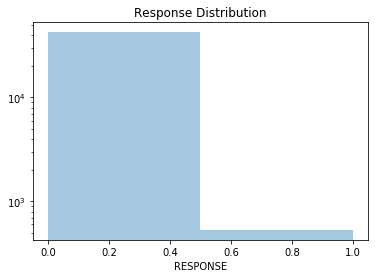

In [11]:
ax = sns.distplot(target_df.RESPONSE, bins=2, kde=False)
ax.set_yscale('log')
_ = ax.set_title('Response Distribution')

#### Split train data
We will split the train data into train and test sets so we can use this test set for validation.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df, df.RESPONSE, test_size=0.33, random_state=42, stratify=df.RESPONSE)
print(len(X_train), len(X_test))

28784 14178


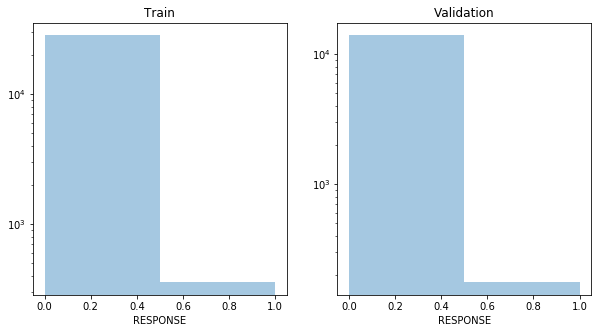

In [13]:
_, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(X_train.RESPONSE, bins=2, kde=False, ax=axes[0])
axes[0].set_yscale('log')
axes[0].set_title('Train')

sns.distplot(X_test.RESPONSE, bins=2, kde=False, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_title('Validation')
plt.show()

#### Save data to S3 to be used by training jobs

In [14]:
bucket.save_csv(X_train, 'training.csv', index=False, header=False)
bucket.save_csv(X_test, 'validation.csv', index=False, header=False)

In [15]:
test_df = bucket.read_parquet('Udacity_MAILOUT_052018_TEST_mm.parquet')
bucket.save_csv(test_df, 'test.csv', index=False, header=False)

In [16]:
pytorch_data_bucket = utils.BucketUtils(bucket_name = 'arvatos-capstone', prefix = 'pytorch_data')
pytorch_data_bucket.save_csv(df, 'train.csv', index=False, header=False) # full training set
pytorch_data_bucket.save_csv(X_train, 'training.csv', index=False, header=False)  # 0.7 fraction of TRAIN set
pytorch_data_bucket.save_csv(X_test, 'validation.csv', index=False, header=False) # 0.3 fraction of TRAIN set

### SKLearn Model

Train a Random Forest Classifier using GridSearchCV.<br>
Using full TRAIN set as we are training with k-fold cross validation

In [18]:
data_location = 's3://{}/{}'.format(pytorch_data_bucket.bucket_name, pytorch_data_bucket.prefix)
pytorch_data_bucket.get_files()

{'pytorch_data/train.csv',
 'pytorch_data/training.csv',
 'pytorch_data/validation.csv'}

#### Train model

Define sklearn estimator

In [19]:
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
script_path = 'train.py'

sklearn_estimator = SKLearn(
                            source_dir='sklearn',
                            entry_point=script_path,
                            framework_version=FRAMEWORK_VERSION,
                            train_instance_type="ml.c4.xlarge",
                            role=role,
                            sagemaker_session=sagemaker_session,
                            hyperparameters={'n_jobs': 4,
                                             'random_state': 42,
                                            })

Train estimator

In [20]:
%%time

# Train your estimator on S3 training data

sklearn_estimator.fit({'train': data_location})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-10-26 23:57:48 Starting - Starting the training job...
2020-10-26 23:57:50 Starting - Launching requested ML instances......
2020-10-26 23:58:57 Starting - Preparing the instances for training......
2020-10-27 00:00:06 Downloading - Downloading input data......
2020-10-27 00:01:14 Training - Training image download completed. Training in progress.......2020-10-27 00:01:14,890 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-10-27 00:01:14,891 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-10-27 00:01:14,901 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-10-27 00:01:15,322 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-10-27 00:01:15,335 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-10-27 00:01:15,347 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus instal

Download model artifacts and check score

In [29]:
bucket_name = sklearn_estimator.output_path[5:-1]
training_job_name = sklearn_estimator._current_job_name
model_key = '{}/output/model.tar.gz'.format(training_job_name)

# download model artifacts
boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
# unzipping as model_algo-1
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

Load model and check score

In [33]:
import joblib

In [34]:
model = joblib.load('model.joblib')

/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ec2-user/anaconda3/envs/pytorch_latest_p36/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [37]:
print('Model score: %.4f' % model.best_score_)

Model score: 0.6899


#### Generate test predictions

In [38]:
%%time

# deploy your model to create a predictor
sklearn_predictor = sklearn_estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------------!CPU times: user 392 ms, sys: 29.6 ms, total: 421 ms
Wall time: 10min 33s


In [ ]:
test_df = bucket.read_parquet('Udacity_MAILOUT_052018_TEST_mm.parquet')
batch_size = 100
predictions = []
for k in range(len(test_df) // batch_size + 1):
    batch = test_df.values[k*batch_size:(k+1)*batch_size, :]
    pred = sklearn_predictor.predict(batch.astype(np.float32))
    predictions.extend(pred)
predictions = np.squeeze(np.vstack(predictions))

#### Save results for Kaggle submission¶


In [44]:
save_for_kaggle(predictions, 'sklearn')

'sklearn_10_27_20__00_39.csv'

#### Cleanup resources


In [ ]:
sklearn_predictor.delete_endpoint()

## Pytorch Model

Train a Pytorch Neural Network with 3 hidden layers using early stopping and regularization to avoid overfitting.

In [ ]:
data_location = 's3://{}/{}'.format(pytorch_data_bucket.bucket_name, pytorch_data_bucket.prefix)
pytorch_data_bucket.get_files()

#### Train model

Define PyTorch estimator

In [32]:
from sagemaker.pytorch import PyTorch

FRAMEWORK_VERSION = "1.0"
output_path = 's3://{}/{}'.format(models_bucket.bucket_name, models_bucket.prefix)

# instantiate a pytorch estimator
pytorch_estimator = PyTorch(entry_point='train.py',
                            source_dir='pytorch',
                            role=role,
                            framework_version=FRAMEWORK_VERSION,
                            train_instance_count=1,
                            train_instance_type='ml.c4.xlarge',
                            output_path=output_path,
                            sagemaker_session=sagemaker_session,
                            hyperparameters={
                                'input_features': 418,  # num of features
                                'lr': 1e-4, # learning rate
                                'l2_reg': 1e-4, # weight decay
                                'hidden_dim1': 64, # dimmension of hidden layer 1
                                'hidden_dim2': 32, # dimmension of hidden layer 2
                                'hidden_dim3': 16, # dimmension of hidden layer 2
                                'output_dim': 1, # number of output classes
                                'dropout_rate': 0.4, # dropout rate
                                'epochs': 100, # number of epochs,
                                'patience': 10, # number of epochs without improvement before early stop
                                'batch-size': 300
                            },
                           )

Train estimator

In [33]:
%%time

# Train estimator on S3 training data
pytorch_estimator.fit({'train': data_location})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-26 01:03:08 Starting - Starting the training job...
2020-10-26 01:03:11 Starting - Launching requested ML instances......
2020-10-26 01:04:21 Starting - Preparing the instances for training...
2020-10-26 01:05:02 Downloading - Downloading input data...
2020-10-26 01:05:24 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-10-26 01:05:49,187 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-10-26 01:05:49,190 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-10-26 01:05:49,203 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-10-26 01:05:52,228 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-10-26 01:05:52,872 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2020-10-26 01:05:52,873

#### Generate test predictions

In [48]:
# deploy and create a predictor
pytorch_predictor = pytorch_estimator.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


-----------------!

In [49]:
# submit batches of data for prediction
test_df = bucket.read_parquet('Udacity_MAILOUT_052018_TEST_mm.parquet')
batch_size = 100
predictions = []
for k in range(len(test_df) // batch_size + 1):
    batch = test_df.values[k*batch_size:(k+1)*batch_size, :]
    pred = pytorch_predictor.predict(batch.astype(np.float32))
    predictions.extend(pred)
predictions = np.squeeze(np.vstack(predictions))

#### Save results for Kaggle submission

In [53]:
save_for_kaggle(predictions, 'pytorch')

'pytorch_10_26_20__01_41.csv'

#### Cleanup resources

In [54]:
pytorch_predictor.delete_endpoint()

## XGBoost model

Train a XGBoost model with hyperparameter tunning

#### Train model

Define an estimator using xgboost container image uri

In [45]:
from sagemaker.estimator import Estimator

# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')
output_path = 's3://{}/{}/output'.format(models_bucket.bucket_name, models_bucket.prefix)

# Create a SageMaker estimator using the container location 
xgb = sagemaker.estimator.Estimator(container,               # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path=output_path,                 # Output path for model artifacts
                                    sagemaker_session=sagemaker_session)

# Set the XGBoost hyperparameters
xgb.set_hyperparameters(silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Define a hyperparameter tuner to search for best parameters in range

In [46]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

# Create the hyperparameter tuner object
xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:auc', # The metric used to compare trained models.
                                               objective_type = 'Maximize', # Whether we wish to minimize or maximize the metric.
                                               max_jobs = 10, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(10, 100),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 20),
                                               })

Define data location

In [47]:
train_location = 's3://{}/{}/{}'.format(bucket.bucket_name, bucket.prefix, 'training.csv')
val_location = 's3://{}/{}/{}'.format(bucket.bucket_name, bucket.prefix, 'validation.csv')
test_location = 's3://{}/{}/{}'.format(bucket.bucket_name, bucket.prefix, 'test.csv')

s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')
s3_input_test = sagemaker.s3_input(s3_data=test_location, content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


Train estimator

In [48]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

In [49]:
xgb_hyperparameter_tuner.wait()

..........................................................................................................................................................................!


Attach to best model found during tuning

In [50]:
# Create a new estimator object attached to the best training job found during hyperparameter tuning
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

# Create a transformer object from the attached estimator. 
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-10-27 00:55:14 Starting - Preparing the instances for training
2020-10-27 00:55:14 Downloading - Downloading input data
2020-10-27 00:55:14 Training - Training image download completed. Training in progress.
2020-10-27 00:55:14 Uploading - Uploading generated training model
2020-10-27 00:55:14 Completed - Training job completed

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


Arguments: train
[2020-10-27:00:54:52:INFO] Running standalone xgboost training.
[2020-10-27:00:54:52:INFO] Setting up HPO optimized metric to be : auc
[2020-10-27:00:54:52:INFO] File size need to be processed in the node: 129.97mb. Available memory size in the node: 8472.13mb
[2020-10-27:00:54:52:INFO] Determined delimiter of CSV input is ','
[00:54:52] S3DistributionType set as FullyReplicated
[00:54:52] 28784x418 matrix with 12031712 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-10-27:00:54:52:INFO] Determined delimiter of CSV input is ','
[00:54:52] S3DistributionType set as FullyReplicated
[00:54:52] 14178x418 matrix with 5926404 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=0&delimiter=,
[00:54:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 0 extra nodes, 2 pruned nodes, max_depth=0
[0]#011train-auc:0.5#011validation-auc:0.5
Multiple eval metrics have been passed: 'validation-auc' will be used fo

#### Generate test predictions

In [51]:
data_dir = 'xgb'
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

.............................2020-10-27T01:00:39.737:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD

Arguments: serve
[2020-10-27 01:00:39 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-10-27 01:00:39 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-10-27 01:00:39 +0000] [1] [INFO] Using worker: gevent
[2020-10-27 01:00:39 +0000] [37] [INFO] Booting worker with pid: 37
[2020-10-27 01:00:39 +0000] [38] [INFO] Booting worker with pid: 38
[2020-10-27 01:00:39 +0000] [39] [INFO] Booting worker with pid: 39
[2020-10-27:01:00:39:INFO] Model loaded successfully for worker : 37
[2020-10-27:01:00:39:INFO] Model loaded successfully for worker : 38
[2020-10-27:01:00:39:INFO] Model loaded successfully for worker : 39
[2020-10-27 01:00:39 +0000] [40] [INFO] Booting worker with pid: 40
Arguments: serve
[2020-10-27 01:00:39 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-10-27 01:00:39 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[

In [52]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

download: s3://sagemaker-us-east-2-089812661404/xgboost-201027-0041-010-9413c60a-2020-10-27-00-56-00-840/test.csv.out to xgb/test.csv.out


#### Save results for Kaggle submission

In [53]:
save_for_kaggle(predictions, 'xgb')

'xgb_10_27_20__01_03.csv'

## Part 3: Kaggle Competition

Now that we've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. 

The to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

#### Result

Test predictions from XGBoost ('xgb_10_27_20__01_03.csv') were submitted to Kaggle, resulting in a test score of 0.71592, which means that, on average, the model is right 71.5% of times it makes a prediction. 